### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [3]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [4]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



### Import a dictionary

Import a bag of words style dictionary for word counting analyses


In [5]:
def get_dictionary(file_path, file_name):
    """Read a standard word list dictionary text file into a list"""
    with open(file_path + file_name, "r") as file:
#         words = [word.lower().rstrip('\n') for word in file]
        words = [word.lower().rstrip() for word in file] # had to strip \r as well on my machine
    return words


## Build a list of files that have valid Q&A sections we want to use

This section reviews all the files and rejects any that do not meet our criteria for use.

In [6]:
# Different possible section headers
CO_PART_HEADERS = ['Company Participants']
OTH_PART_HEADERS = ['Other Participants']
MD_SECTION_HEADERS = ['MANAGEMENT DISCUSSION SECTION', 'Presentation']
QA_SECTION_HEADERS = ['Q&A', 'Questions And Answers', 'QUESTION AND ANSWER SECTION',
                      'QUESTION AND ANSWER SESSION', 'QUESTION-AND-ANSWER SECTION']
DISCLAIMER = ['This transcript may not be 100 percent accurate ']


In [7]:

# New text file format has headers
def remove_header_footers(ts):
    i = 0
    header_footer = []
    # Add all the lines before the first 'Page 1 of n' line
    while ts[i].find('Page') == -1:
#         if ts[i].find('Fixed') != -1:
#             print (ts[1], ts[2])
        header_footer.append(ts[i])
        i += 1
    # Extract the total page number and add lines to strip for all the 
    # 'Page x of n' line
    pages = ts[i]
    pages = pages.split(' ')
    page_num = int(pages[-1])
    for i in range(1, page_num + 1):
        header_footer.append('Page ' + str(i) + ' of ' + str(page_num))
    ts = [line for line in ts if line not in header_footer]
    return ts


def read_transcript(file_path):
    # read in all lines of the transcript
    with open(file_path, "r") as file:
        ts = file.readlines()
        ts = [str(unicode(line, errors = 'ignore')) for line in ts]
        ts = [line.rstrip() for line in ts]
        ts = remove_header_footers(ts)
    return ts


# Find the index value of a full string from a list of possible strings
def find_full_string_index(ts, string_list):
    result = -1
    for i in range(len(string_list)):
        if string_list[i] in ts:
            result = ts.index(string_list[i])
    return result

# Find the index of the disclaimer
def find_disclaimer_index(ts, string_list):
    result = -1
    k = len(ts) - 1
    while True:
        for my_str in string_list:
            if ts[k].find(my_str) != -1:
                result = k
                break
        k -= 1
        if k < 0:
            break
    return result

# Get transcript list indices from a single transcript
def get_basic_parameters(ts):
    call_type = ts[0]
    # check call type
    if call_type.find("Earnings Call") == -1:
        call_type = -1
    else:
        if call_type.find("Fixed") != -1:  # don't want Fixed Income calls
            call_type = -1
            
    co_parts = find_full_string_index(ts,CO_PART_HEADERS)
    oth_parts = find_full_string_index(ts,OTH_PART_HEADERS)
    md = find_full_string_index(ts,MD_SECTION_HEADERS)
    qa = find_full_string_index(ts,QA_SECTION_HEADERS)
    disc = find_disclaimer_index(ts,DISCLAIMER)
    return [call_type, co_parts, oth_parts, md, qa, disc]


In [8]:
# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

def get_files_from_dirs(directory_list, file_type):
    # Read in all the files from subdirectories into a master list
    
    matchfiles = []
    for d in directory_list:
        matchfiles.extend(get_files(LIBRARY_PATH+d+"/",'txt'))    
    return matchfiles

def find_valid_files(file_list):
    '''Scans all the files in the file list and returns a list of those which
       pass all QA checks, and a list of those that do not, with reason why'''
    
    good_files = []
    problems = []

    for path in file_list:
        ts = read_transcript(path)
        params = get_basic_parameters(ts)
        
        errs = ["not equity earnings call",
                "no co participants",
                "no other participants",
                "no mgmt discussion section",
                "no Q&A section",
                "no disclaimer"
                ]
        
        errs_found = []
        for i, err in enumerate(errs):
            if params[i] == -1:
                errs_found.append(err)
        
        if len(errs_found) == 0:
            good_files.append(path)
        else:
            problems.append((errs_found, path, params))

    return good_files, problems


files_to_check = get_files_from_dirs(TEXT_DIR_LIST, "txt")
TextFiles, error_files = find_valid_files(files_to_check)

print "Valid Files found: ", len(TextFiles)
print
print "Files rejected:", len(error_files)
print
err_counts = defaultdict(int)
err_lists = defaultdict(list)
for f in error_files:
    for err in f[0]:
        err_counts[err] += 1
        err_lists[err].append(f[1])

print "Number of files with each type of error (file can have >1 error):"
for err in err_counts:
    print err, err_counts[err]
    print "Files are:"
    for f in err_lists[err]:
        print f

Valid Files found:  3245

Files rejected: 103

Number of files with each type of error (file can have >1 error):
no Q&A section 42
Files are:
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100806_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100817_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101105_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101110_1_GM.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101116_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110816_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20111115_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120221_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120816_1_WMT.txt
/Users/seddo

In [9]:
TextFiles[:5]

['/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_AEP.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_CVX.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_MET.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_MRK.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_SPG.txt']

### Pre-processing functions

In [10]:
def remove_square_brackets(my_str):
    return re.sub(r'\[.+?\]', '', my_str)

def remove_square_brackets_transcript(ts):
    return list(map(lambda line: remove_square_brackets(line), ts))


In [11]:
# Find participants on the call
def get_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    # Check for problematic names
    extra_names = []
    for name in result:
        # Find any title after name and remove it
        if name.find(',') != -1:
            name_only = name[:name.find(',')]
            extra_names.append(name_only)
        # Find names with middle initials and remove them
        elif name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    # Find names in extra names with middle initials and remove them
    for name in extra_names:
        if name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    return result + extra_names

# Remove middle initial from a name
def remove_middle_initials(my_str):
    # count = 0
    while True:
        if my_str.find('.') != -1:
            new_my_str = re.sub(r'(\s)([A-Z].)(\s)', r"\1", my_str)
            if new_my_str == my_str:
                break
            else:
                my_str = new_my_str
            # count += 1
            # if count >= 10:
            #     break
        else:
            break
    return my_str


In [12]:
# Find a section of the call
def get_section(ts, start_index, end_index):
    result = ts[start_index+1:end_index]
    result = [line for line in result if line not in ['\x0c']]   # clean the transcript for unnecessary lines
    return result


In [13]:
def get_MD(ts, names, start_index, end_index):

    curr_speaker = ""
    section_header = "MD"
    
    # Create an empty dict for comments by each manager
    pts = {name: "" for name in names}

    # Get the required section
    section = get_section(ts, start_index, end_index)
    
    # Find the first instance of a co_parts speaker
    start_section = 0
    while True:
        if section[start_section] not in names:
            start_section += 1
        else:
            break
        if start_section == len(section):
            start_section = -1
            break

    if start_section == -1:
        pts['No speaker found'] = section_header
    else:
        # Reduce MD Section to management speaking only
        section = section[start_section:]
        # populate comment dict
        for line in section:
            if line in names:
                curr_speaker = line
            elif len(line) != 0:
                pts[curr_speaker] += line + " "

    return pts


In [14]:
# This procedure combines the raw Q&A section into pairs of questions and answers in a dictionary

def get_QA(ts, start_index, end_index):

    pts = {}
    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    q_or_a = None
    currQ = ''
    currA = ''
    
    for line in qa_section:
        line = remove_square_brackets(line)
        if len(line) > 0:                                     # if line is '' then ignore otherwise process the line
            if line == 'Operator':                            # if line is 'Operator' then set everything NULL and ignore
                q_or_a = None
                currQ = ''
                currA = ''
            if line[0] == "<":                                # if Q or A found do something
                if line[0:2] == "<Q":
                    if q_or_a == 'A':                         # if Q found and q_or_a is not NULL then add Q: A to the dictionary
                        pts[currQ[:-1]] = currA[:-1]          # and reset the parameters to NULL
                        currQ = ''
                        currA = ''
                        q_or_a = None    
                    end_qa_tag = line.find(">")
                    currQ += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'Q'                              # Given Q found set q_or_a = 'Q'
                if line[0:2] == "<A":
                    end_qa_tag = line.find(">")             
                    currA += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'A'                              # Given Q found set q_or_a = 'Q'
            else:                                             
                if q_or_a is not None:                        # Other if currently a Q or A just concatenate the string 
                    if q_or_a == 'Q':
                        currQ += line + " "
                    else:
                        currA += line + " "

    if currQ != '' and currA != '':                           # Add last Q: A pair to the dictionary if necessary
        pts[currQ[:-1]] = currA[:-1]

    return pts




### Bespoke cleaning

The following procedures deal with strings with words that have apostrophes, hyphens, slashes and unusual characters in them to help best isolate actual words.

In [15]:
def short_form_replace(my_str):
    """Convert apostrophes in known short-forms in my_string to long-forms"""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = re.sub(r'let\'s', "let us", my_str)
    my_str = re.sub(r'Let\'s', "let us", my_str)
    my_str = re.sub(r'won\'t', "will not", my_str)
    my_str = re.sub(r'can\'t', "cannot", my_str)
    my_str = re.sub(r'shan\'t', "shall not", my_str)
    my_str = re.sub(r'Won\'t', "Will not", my_str)
    my_str = re.sub(r'Can\'t', "Cannot", my_str)
    my_str = re.sub(r'Shan\'t', "Shall not", my_str)
    my_str = re.sub(r'n\'t', " not", my_str)
    my_str = re.sub(r'\'ve', " have", my_str)
    my_str = re.sub(r'\'re', " are", my_str)
    my_str = re.sub(r'\'m', " am", my_str)
    my_str = re.sub(r'\'ll', " will", my_str)
    my_str = re.sub(r'\'d', " would", my_str)     # note could also be did or had as well
    my_str = re.sub(r'it\'s', "it is", my_str)
    my_str = re.sub(r'he\'s', "he is", my_str)
    my_str = re.sub(r'she\'s', "she is", my_str)
    my_str = re.sub(r'that\'s', "that is", my_str)
    my_str = re.sub(r'what\'s', "what is", my_str)
    my_str = re.sub(r'here\'s', "here is", my_str)
    my_str = re.sub(r'there\'s', "there is", my_str)
    my_str = re.sub(r'who\'s', "who is", my_str)
    my_str = re.sub(r'It\'s', "It is", my_str)
    my_str = re.sub(r'He\'s', "He is", my_str)
    my_str = re.sub(r'She\'s', "She is", my_str)
    my_str = re.sub(r'Shat\'s', "That is", my_str)
    my_str = re.sub(r'What\'s', "What is", my_str)
    my_str = re.sub(r'Here\'s', "Here is", my_str)
    my_str = re.sub(r'There\'s', "There is", my_str)
    my_str = re.sub(r"Who's", "Who is", my_str)
    return my_str


def apostrophe_s_replace(my_str):
    """Remove 's at the end of words in my_string. Best to run this after short_form_replace()"""
    my_str = re.sub(r"([A-z])\'s", r"\1", my_str)
    return my_str


def hyphen_replace(my_str):
    """Replace hyphens in hyphenated words with a space"""
    my_str = re.sub(r"([A-z])(\-)([A-z])", r"\1 \3", my_str)
    my_str = re.sub(r"([A-z])(\-)(\s)([A-z])", r"\1 \4", my_str)
    return my_str


def forward_slash_replace(my_str):
    """Replace forward slashes in combined words with a space."""
    my_str = re.sub(r"([A-z])(/)([A-z])", r"\1 \3", my_str)
    my_str = my_str.replace(')/', ' ')
    my_str = my_str.replace('/(', ' ')
    return my_str


def replace_apostrophes(my_str):
    """Tidy up my_string for all apostrophe-related issues."""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = short_form_replace(my_str)
    my_str = apostrophe_s_replace(my_str)
    return my_str


def clean_text(my_str):
    """Clean my_string for all known string issues to prepare for text analysis"""
    my_str = replace_apostrophes(my_str)
    my_str = hyphen_replace(my_str)
    my_str = forward_slash_replace(my_str)
    return my_str


def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



#### Example

### Tokenization

In [16]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

### Stop Words

In [17]:
# Import stop words list
stop_words = get_dictionary(LIBRARY_PATH,'stop_words.txt')

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seddont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords

In [20]:
# Create English stop words list from NLTK
nltk_stop_words = stopwords.words('english')

In [21]:
stop_words = sorted(list(set(stop_words + nltk_stop_words)))

### Stemming

In [22]:
from nltk.stem.porter import PorterStemmer

In [23]:
def get_filename_components(file_path, i):
    file_name_and_ext = os.path.basename(file_path)
    name_only = os.path.splitext(file_name_and_ext)[0]
    date, file_num, ticker = name_only.split("_")
    
    return (ticker, date, file_num)
    

# LDA Approach

http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

### Install packages

In [24]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org gensim

In [25]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org smart_open

In [26]:
def replace_number(token):
    if token.isdigit():
        return "NUM"
    else:
        return token

In [27]:
test_doc = ['okay', u'current', 'end', 'year', '2011']
[replace_number(t) for t in test_doc]

['okay', u'current', 'end', 'year', 'NUM']

In [28]:
def testLDA_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [t for t in tokens if not t in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    replaced_num_tokens = [replace_number(t) for t in stemmed_tokens]
    return replaced_num_tokens

### Learn topic model, apply to Q&A pairs and evaluate similarity of Qs and As

In [29]:
def extract_raw_qa(source_list, output_file):
    '''Extract raw Q and A text from a list of files and put a structured dictionary
       of the extracted Q & A pairs into an output file.
       
       Returns a dictionary of raw Q&A pairs'''
    
    rawtext_qa = defaultdict(dict)
    i = 0
    report_every = 500
    start_time = time.time()
    
    for f in source_list:
    
        (ticker, date, file_num) = get_filename_components(f, i)

        file_id = ticker+"_"+date

        ts = read_transcript(f)

        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)

            # get the QA pairs with a condition to ensure both of at least some length
            q_number = 0
            for question in QA:

                # store indexed rawtext for easier inspection later
                rawtext_qa[file_id][q_number] = (question, QA[question])
                
                q_number += 1

        i += 1
        if i % report_every == 0:
            print "Processed ", i, "transcripts in ", time.time() - start_time, "seconds"
            
    # Also store the rawtext pairs, for easier inspection later
    with open(output_file, "w") as f:
        f.write(json.dumps(rawtext_qa))
    
    print "Finished extracting q and a text from all", i, "transcripts in ", time.time() - start_time, "seconds"
    
    return rawtext_qa

In [30]:
def save_model_spec(model_spec):
    '''Saves a model spec as a JSON in its specified directory'''
    if not os.path.exists(LIBRARY_PATH + model_spec["model_directory"]):
        os.mkdir(LIBRARY_PATH + model_spec["model_directory"])

    # Store the processed tokens in qa_pairs
    model_spec_path = LIBRARY_PATH+model_spec["model_directory"]+"/model_spec.txt"
    with open(model_spec_path, "w") as f:
        f.write(json.dumps(model_spec))

In [31]:
def process_raw_qa_pairs(rawtext_qa, model_spec):
    '''Turns raw text q and a pairs into processed token sequences using prepro_func
       passed to it.
       
       Returns a dictionary of processed q and a pairs.'''
    
    qa_pairs = defaultdict(dict)
    start_time = time.time()
    i = 0
    report_every = 2500
    
    prepro_func = PREPRO_FUNCTIONS[model_spec["preprocessing_function"]]
    
    # Assemble a unified training texts list from all the qualifying processed Q&A pairs found
    for file_id in rawtext_qa:
        for q_number in rawtext_qa[file_id]:
            
            procd_question = prepro_func(rawtext_qa[file_id][q_number][0])
            procd_answer = prepro_func(rawtext_qa[file_id][q_number][1])
            
            qa_pairs[file_id][q_number] = (procd_question, procd_answer)
            
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in ", time.time() - start_time, "seconds"
                    
    print "Finished all", i, "raw q and a pairs in ", time.time() - start_time, "seconds"
            
    return qa_pairs


In [32]:
def select_texts(qa_pairs, model_spec):
    '''Assembles a unified set of training texts, that conforms with the 
       model specification.'''
    
    # Assemble a unified training texts list from all the qualifying processed Q&A pairs found
    texts = []
    min_sequence_length = model_spec["min_sequence_length"]
    
    count_accepted = 0
    count_rejected = 0
    
    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                texts.append(question)
                texts.append(answer)
                count_accepted += 1
            else:
                count_rejected +=1
                
    print count_accepted, "pairs met minimum length."
    print count_rejected, "were rejected."
                
    return texts

In [33]:
def learn_LDA_model(model_spec, texts, passes = 10, iterations = 50):
    '''Learns an LDA model according to the model spec and stores the associated files'''
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    
    # Set up logging to file for Gensim progress

    # Clear any other logging handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        
    logging.basicConfig(filename=model_dir+'/lda_logfile.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
   
    # Convert the texts from all the Questions and Answers into integer form and save
    dictionary = corpora.Dictionary(texts)
    dictionary.save(model_dir+"/dictionary.txt")
    
    # Create and save corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    with open(model_dir+"/corpus.txt", "w") as f:
        f.write(json.dumps(corpus))
        
    # Fit the LDA model

    start_time = time.time()
    print "fitting model"
    # Fit LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                               num_topics=model_spec["num_topics"],
                                               id2word = dictionary,
                                               passes=passes,
                                               iterations = iterations,
                                               eval_every = 10)
    
    print "model fitting took", time.time() - start_time, "seconds"
    
    # Remove logging handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # Save the learned model to file
    ldamodel.save(model_dir + "/full_model")
    
    # Save a UTC timestamp into the directory
    model_run_at = str(datetime.datetime.utcnow())
    with open(model_dir+"/model_runtime.txt", "w") as f:
        f.write(model_run_at)
        
    

In [34]:
def calc_hellinger_sims(model_spec):
    '''Calc hellinger similarities for a model and its data.'''

    hellinger_sims = defaultdict(dict)
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
        
    ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
    dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")

    start_time = time.time()
    i = 0
    report_every = 5000
    
    min_sequence_length = model_spec["min_sequence_length"]

    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                q_bow = dictionary.doc2bow(question)
                a_bow = dictionary.doc2bow(answer)
                lda_q_bow = ldamodel[q_bow]
                lda_a_bow = ldamodel[a_bow]
                hellinger_sims[file_id][q_number] = hellinger(lda_q_bow, lda_a_bow)
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in", time.time() - start_time
    print "Finished in", time.time() - start_time
    
    # Store the corpus to file for recreating model later if wanted
    with open(model_dir+"/hell_sims.txt", "w") as f:
        f.write(json.dumps(hellinger_sims))
    

## Restoring from a saved state

Since training the models and processing the text is quite time consuming, it's useful to be able to restore a saved model.  Gensim makes saving and restoring a model easy, but we will often want to also be able to look at the data associated with that model.  This data may not always be the same, because we may apply different preprocessing to the raw transcript text to test the impact of that on the quality of the models.

We also may want to generate multiple models from the same processed set of data with different LDA hyperparameters (e.g. number of topics) so the same inpiut data might be associated with multiple LDA models.

To make this easy during experimentation this is a class that recovers a saved state from files on disk.  The state is specified by the model_spec dictionary of files so it is very easy to handle any combination of data and models (as long as we kept track in the first place of what data created what model).

In [35]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

## Extracting information to inspect topics and errors

## Running with different parameters

In [40]:
model_spec = {"model_directory": "saved_models/topic10_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 10,
              "description": "Topics 10, Min Length 20, Standard preprocessing"}

# maps function specs to function object
PREPRO_FUNCTIONS = {"testLDA_pre_process_document": testLDA_pre_process_document}

### Run a model with higher number of iterations to compare convergence performance

In [37]:
# Create a list of model specs to run

num_topics_list = [10, 20, 40]
min_length_list = [10, 20, 40]
pre_pro_list = [("base", "testLDA_pre_process_document")]
passes_list = [20]
iterations_list = [100]

model_spec_list = []

for num_topics in num_topics_list:
    for min_length in min_length_list:
        for pre_pro in pre_pro_list:
            for passes in passes_list:
                for iterations in iterations_list:
                
                    dir_name = "top"+str(num_topics)+\
                               "_len"+str(min_length)+\
                               "_pre"+pre_pro[0]+\
                               "_ps"+str(passes)+\
                               "_it"+str(iterations)

                    model_dir = "saved_models/"+dir_name

                    model_spec = {"model_directory": model_dir,
                  "qa_pair_directory": "saved_models/standard_preproc",
                  "preprocessing_function": pre_pro[1],
                  "min_sequence_length": min_length,
                  "num_topics": num_topics,
                  "passes": passes,
                  "iterations": iterations,
                  "description": "Topics "+str(num_topics)+\
                                  ", Min Length "+str(min_length)+\
                                  ", "+pre_pro[0]+" preprocessing"+\
                                  ", passes"+str(passes)+\
                                  ", iterations"+str(iterations)}

                    model_spec_list.append(model_spec)

model_spec_list

[{'description': 'Topics 10, Min Length 10, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 10,
  'model_directory': 'saved_models/top10_len10_prebase_ps20_it100',
  'num_topics': 10,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/standard_preproc'},
 {'description': 'Topics 10, Min Length 20, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 20,
  'model_directory': 'saved_models/top10_len20_prebase_ps20_it100',
  'num_topics': 10,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/standard_preproc'},
 {'description': 'Topics 10, Min Length 40, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/top10_len40_prebase_ps20_it100',
  'num_topics': 10,
  'passes': 20,
  'preprocessing_function': 'testL

In [38]:
# Can just load already preprocessed qa pairs as applying standard preprocessing
qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

for model_spec in model_spec_list:
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts, passes = model_spec["passes"], iterations = model_spec["iterations"])

    calc_hellinger_sims(model_spec)

50433 pairs met minimum length.
34373 were rejected.
fitting model
model fitting took 2595.53394294 seconds
Processed  5000 pairs in 6.21942782402
Processed  10000 pairs in 12.4161520004
Processed  15000 pairs in 18.8181989193
Processed  20000 pairs in 24.906886816
Processed  25000 pairs in 31.0879378319
Processed  30000 pairs in 37.1491379738
Processed  35000 pairs in 43.3238339424
Processed  40000 pairs in 49.5357439518
Processed  45000 pairs in 55.7631449699
Processed  50000 pairs in 61.9721388817
Processed  55000 pairs in 67.950168848
Processed  60000 pairs in 74.2484929562
Processed  65000 pairs in 80.2668848038
Processed  70000 pairs in 86.1547529697
Processed  75000 pairs in 92.6742429733
Processed  80000 pairs in 98.6693148613
Finished in 104.354513884
37304 pairs met minimum length.
47502 were rejected.
fitting model
model fitting took 2063.00563502 seconds
Processed  5000 pairs in 5.23531413078
Processed  10000 pairs in 10.4128570557
Processed  15000 pairs in 15.6498150826
Pr

## Parse log file

In [39]:
def parse_logfile(loglines):
    '''Parses a gensim logfile to return a list of key information from each pass.
       List contains
       pass number
       per word bound
       perplexity
       held out size
       number converged
       number out of which converged
       '''

    match_doc = re.compile("(-*\d+) documents")
    match_perp = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity .* (\d+) documents")
    match_pass = re.compile("pass (\d+).*document #(\d+)")
    match_converged = re.compile("(\d+)\/(\d+) documents converged")

    perp_list = []

    for i in range(len(loglines)):
        if "running online" in loglines[i]:
            # summary of data for the the model run
            total_docs = match_doc.findall(loglines[i])[0]
        if "perplexity estimate" in loglines[i]:
            if "PROGRESS" in loglines[i+1]:
                progress_data = match_pass.findall(loglines[i+1])
                doc_num = progress_data[0][1]
                # only add data for the end of each complete pass
                if doc_num == total_docs:
                    pass_num = progress_data[0][0]
                    perp_data = match_perp.findall(loglines[i])
                    word_bound = perp_data[0][0]
                    perplexity = perp_data[0][1]
                    held_out = perp_data[0][2]
                    converged_data = match_converged.findall(loglines[i+3])
                    converged = converged_data[0][0]
                    out_of = converged_data[0][1]
                    perp_list.append((pass_num, word_bound, perplexity, held_out, converged, out_of))
                    
    return perp_list

In [56]:
model_dir = LIBRARY_PATH+"saved_models/top20_len10_prebase_ps20_it100"
logfile = model_dir + "/lda_logfile.log"
with open(logfile) as f:
    loglines = f.readlines()

parse_logfile(loglines)

[('0', '-7.110', '138.2', '866', '848', '866'),
 ('1', '-7.087', '135.9', '866', '855', '866'),
 ('2', '-7.081', '135.4', '866', '854', '866'),
 ('3', '-7.079', '135.2', '866', '853', '866'),
 ('4', '-7.077', '135.1', '866', '854', '866'),
 ('5', '-7.076', '135.0', '866', '851', '866'),
 ('6', '-7.075', '134.8', '866', '855', '866'),
 ('7', '-7.074', '134.7', '866', '854', '866'),
 ('8', '-7.073', '134.7', '866', '859', '866'),
 ('9', '-7.073', '134.6', '866', '855', '866'),
 ('10', '-7.072', '134.5', '866', '855', '866'),
 ('11', '-7.072', '134.5', '866', '854', '866'),
 ('12', '-7.071', '134.4', '866', '856', '866'),
 ('13', '-7.070', '134.4', '866', '859', '866'),
 ('14', '-7.070', '134.4', '866', '859', '866'),
 ('15', '-7.069', '134.3', '866', '852', '866'),
 ('16', '-7.069', '134.3', '866', '856', '866'),
 ('17', '-7.068', '134.2', '866', '856', '866'),
 ('18', '-7.068', '134.1', '866', '858', '866'),
 ('19', '-7.067', '134.1', '866', '856', '866')]

In [58]:
final_perp = dict()

for model_spec in model_spec_list:
    model_dir = model_spec["model_directory"]
    logfile = LIBRARY_PATH+model_dir+"/lda_logfile.log"
    with open(logfile) as f:
        loglines = f.readlines()
    final_perp[model_dir] = parse_logfile(loglines)
    print model_dir
    print final_perp[model_dir][-1]

saved_models/top10_len10_prebase_ps20_it100
('19', '-7.002', '128.1', '866', '862', '866')
saved_models/top10_len20_prebase_ps20_it100
('19', '-6.986', '126.7', '608', '601', '608')
saved_models/top10_len40_prebase_ps20_it100
('19', '-6.907', '120.0', '490', '481', '490')
saved_models/top20_len10_prebase_ps20_it100
('19', '-7.067', '134.1', '866', '856', '866')
saved_models/top20_len20_prebase_ps20_it100
('19', '-7.021', '129.9', '608', '604', '608')
saved_models/top20_len40_prebase_ps20_it100
('19', '-6.912', '120.4', '490', '487', '490')
saved_models/top40_len10_prebase_ps20_it100
('19', '-7.166', '143.6', '866', '862', '866')
saved_models/top40_len20_prebase_ps20_it100
('19', '-7.123', '139.4', '608', '606', '608')
saved_models/top40_len40_prebase_ps20_it100
('19', '-6.967', '125.1', '490', '488', '490')


## Changing the preprocessing

In [47]:
def remove_highdf_words(qa_pairs, threshold):
    '''Evaluate a list of qa_pairs, calculates a list of words
       with a document frequency higher than the threshold and
       returns the qa_pairs list with those words removed.'''
    
    docf = defaultdict(int)
    total_docs = 0
    for file_id in qa_pairs:
        for q_num in qa_pairs[file_id]:
            q_words = set(qa_pairs[file_id][q_num][0])
            a_words = set(qa_pairs[file_id][q_num][1])
            for word in q_words:
                docf[word] += 1
            for word in a_words:
                docf[word] += 1
            total_docs += 2

    df_stopwords = [w for w in docf if docf[w]*1.0/total_docs > threshold]
    
    for file_id in qa_pairs:
        for q_num in qa_pairs[file_id]:
            q_words = qa_pairs[file_id][q_num][0]
            a_words = qa_pairs[file_id][q_num][1]
            q_words = [w for w in q_words if w not in df_stopwords]
            a_words = [w for w in a_words if w not in df_stopwords]
            qa_pairs[file_id][q_num] = (q_words, a_words)

    return qa_pairs


In [41]:
# model_spec = {'description': 'Topics 20, Min Length 20, base preprocessing, passes20, iterations100, df=0.1',
#   'iterations': 100,
#   'min_sequence_length': 20,
#   'model_directory': 'saved_models/top20_len20_prebase_ps20_it100_df10',
#   'num_topics': 20,
#   'passes': 20,
#   'preprocessing_function': 'testLDA_pre_process_document',
#   'qa_pair_directory': 'saved_models/df_10'},

Not actually changing the previous pre-processing so can just load the qa pairs

In [65]:
qa_dir = LIBRARY_PATH+"saved_models/standard_preproc"
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

In [67]:
for threshold in [0.05, 0.1, 0.2]:
    
    qa_dir = LIBRARY_PATH+"saved_models/standard_preproc"
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())

    stopped_qa_pairs = remove_highdf_words(qa_pairs, threshold)
    
    qa_path = LIBRARY_PATH+"saved_models/base_plus_df"+str(int(threshold*100))+"/qa_pairs.txt"
    with open(qa_path, "w") as f:
        f.write(json.dumps(stopped_qa_pairs))

## Check the removal of high df terms has worked as expected 

In [69]:
qa_dir = LIBRARY_PATH+"saved_models/base_plus_df10"
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

docf = defaultdict(int)
total_docs = 0
for file_id in qa_pairs:
    for q_num in qa_pairs[file_id]:
        q_words = set(qa_pairs[file_id][q_num][0])
        a_words = set(qa_pairs[file_id][q_num][1])
        for word in q_words:
            docf[word] += 1
        for word in a_words:
            docf[word] += 1
        total_docs += 2
        
print total_docs
             
doc_freqs = [(w, docf[w]*1.0/total_docs) for w in docf]
doc_freqs = sorted(doc_freqs, key = lambda w: w[1], reverse = True)
doc_freqs

169612


[(u'number', 0.09735160248095653),
 (u'product', 0.0961075867273542),
 (u'make', 0.09574204655330991),
 (u'give', 0.0934014102775747),
 (u'mayb', 0.09336603542202203),
 (u'said', 0.09211022804990213),
 (u'price', 0.0920630615758319),
 (u'way', 0.08928613541494705),
 (u'still', 0.08827795203169587),
 (u'got', 0.08794189090394547),
 (u'obvious', 0.08691012428365917),
 (u'rate', 0.08558946300969271),
 (u'chang', 0.08360257528948424),
 (u'two', 0.08155672947668798),
 (u'mean', 0.07972313279720775),
 (u'actual', 0.07664552036412518),
 (u'start', 0.07624460533452822),
 (u'work', 0.07567271183642667),
 (u'impact', 0.07550173336792208),
 (u'new', 0.07527769261608848),
 (u'cost', 0.07495931891611443),
 (u'around', 0.07491804825130298),
 (u'next', 0.07426361342357853),
 (u'second', 0.07329670070513879),
 (u'great', 0.07115062613494329),
 (u'guess', 0.0692757587906516),
 (u'pretti', 0.06898096832771267),
 (u'forward', 0.06878640662217296),
 (u'part', 0.06866849043699738),
 (u'sure', 0.06789613942

## Learn new models using the qa pairs with high df words removed

Just going to run one set of topics/min length for now.

In [71]:
model_spec_list = [
    {'description': 'Topics 20, Min Length 20, base plus df 0.05 threshold',
  'iterations': 100,
  'min_sequence_length': 20,
  'model_directory': 'saved_models/top20_len20_prebase_df5',
  'num_topics': 20,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df5'},
    {'description': 'Topics 20, Min Length 20, base plus df 0.10 threshold',
  'iterations': 100,
  'min_sequence_length': 20,
  'model_directory': 'saved_models/top20_len20_prebase_df10',
  'num_topics': 20,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df10'},
    {'description': 'Topics 20, Min Length 20, base plus df 0.20 threshold',
  'iterations': 100,
  'min_sequence_length': 20,
  'model_directory': 'saved_models/top20_len20_prebase_df20',
  'num_topics': 20,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df20'}]

In [72]:
# Need to reload new qa_pairs for each model now, as preprocessing varies

for model_spec in model_spec_list:
    
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts, passes = model_spec["passes"], iterations = model_spec["iterations"])

    calc_hellinger_sims(model_spec)

15640 pairs met minimum length.
69166 were rejected.
fitting model
model fitting took 931.181818008 seconds
Processed  5000 pairs in 2.64878702164
Processed  10000 pairs in 4.90529704094
Processed  15000 pairs in 7.08386707306
Processed  20000 pairs in 9.15109395981
Processed  25000 pairs in 11.4138550758
Processed  30000 pairs in 13.5412130356
Processed  35000 pairs in 15.7022058964
Processed  40000 pairs in 17.811396122
Processed  45000 pairs in 20.0527279377
Processed  50000 pairs in 22.2290399075
Processed  55000 pairs in 24.2675149441
Processed  60000 pairs in 26.498748064
Processed  65000 pairs in 28.5355629921
Processed  70000 pairs in 30.5012960434
Processed  75000 pairs in 32.8700919151
Processed  80000 pairs in 34.9338350296
Finished in 36.8963549137
26275 pairs met minimum length.
58531 were rejected.
fitting model
model fitting took 1681.23539281 seconds
Processed  5000 pairs in 4.25869202614
Processed  10000 pairs in 8.44302487373
Processed  15000 pairs in 12.8299229145
Pr

In [73]:
final_perp = dict()

for model_spec in model_spec_list:
    model_dir = model_spec["model_directory"]
    logfile = LIBRARY_PATH+model_dir+"/lda_logfile.log"
    with open(logfile) as f:
        loglines = f.readlines()
    final_perp[model_dir] = parse_logfile(loglines)
    print model_dir
    print final_perp[model_dir][-1]

saved_models/top20_len20_prebase_df5
('19', '-7.704', '208.6', '1280', '1278', '1280')
saved_models/top20_len20_prebase_df10
('19', '-7.423', '171.7', '550', '549', '550')
saved_models/top20_len20_prebase_df20
('19', '-7.209', '147.9', '848', '839', '848')


### Going to learn new models around 40/40 as it gave good portfolio results

In [41]:
# Create a list of model specs to run

num_topics_list = [30, 40, 50]
min_length_list = [30, 40, 50]
pre_pro_list = [("base", "testLDA_pre_process_document")]
passes_list = [20]
iterations_list = [100]

model_spec_list = []

for num_topics in num_topics_list:
    for min_length in min_length_list:
        for pre_pro in pre_pro_list:
            for passes in passes_list:
                for iterations in iterations_list:
                
                    dir_name = "1216_top"+str(num_topics)+\
                               "_len"+str(min_length)+\
                               "_pre"+pre_pro[0]\


                    model_dir = "saved_models/"+dir_name

                    model_spec = {"model_directory": model_dir,
                  "qa_pair_directory": "saved_models/standard_preproc",
                  "preprocessing_function": pre_pro[1],
                  "min_sequence_length": min_length,
                  "num_topics": num_topics,
                  "passes": passes,
                  "iterations": iterations,
                  "description": "Topics "+str(num_topics)+\
                                  ", Min Length "+str(min_length)+\
                                  ", "+pre_pro[0]+" preprocessing"+\
                                  ", passes"+str(passes)+\
                                  ", iterations"+str(iterations)}

                    model_spec_list.append(model_spec)

model_spec_list

[{'description': 'Topics 30, Min Length 30, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 30,
  'model_directory': 'saved_models/1216_top30_len30_prebase',
  'num_topics': 30,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/standard_preproc'},
 {'description': 'Topics 30, Min Length 40, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/1216_top30_len40_prebase',
  'num_topics': 30,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/standard_preproc'},
 {'description': 'Topics 30, Min Length 50, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 50,
  'model_directory': 'saved_models/1216_top30_len50_prebase',
  'num_topics': 30,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_doc

In [42]:
# Can just load already preprocessed qa pairs as applying standard preprocessing
qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

for model_spec in model_spec_list:
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts, passes = model_spec["passes"], iterations = model_spec["iterations"])

    calc_hellinger_sims(model_spec)

23983 pairs met minimum length.
60823 were rejected.
fitting model
model fitting took 2177.52697301 seconds
Processed  5000 pairs in 4.66460490227
Processed  10000 pairs in 9.61262893677
Processed  15000 pairs in 14.3877160549
Processed  20000 pairs in 18.8593599796
Processed  25000 pairs in 23.7596209049
Processed  30000 pairs in 28.4057168961
Processed  35000 pairs in 33.0510339737
Processed  40000 pairs in 37.7700738907
Processed  45000 pairs in 42.4985659122
Processed  50000 pairs in 47.3980169296
Processed  55000 pairs in 52.2415890694
Processed  60000 pairs in 57.2489650249
Processed  65000 pairs in 61.8114099503
Processed  70000 pairs in 66.2170388699
Processed  75000 pairs in 71.5379519463
Processed  80000 pairs in 75.9677929878
Finished in 80.264359951
13245 pairs met minimum length.
71561 were rejected.
fitting model
model fitting took 1137.70855904 seconds
Processed  5000 pairs in 2.94407510757
Processed  10000 pairs in 5.97144293785
Processed  15000 pairs in 8.95537400246
P

In [61]:
# Create a list of model specs to run

num_topics_list = [40]
min_length_list = [40]
pre_pro_list = [("base", "testLDA_pre_process_document")]
passes_list = [20]
iterations_list = [100]

model_spec_list = []

for num_topics in num_topics_list:
    for min_length in min_length_list:
        for pre_pro in pre_pro_list:
            for passes in passes_list:
                for iterations in iterations_list:
                
                    dir_name = "Check_top"+str(num_topics)+\
                               "_len"+str(min_length)+\
                               "_pre"+pre_pro[0]\


                    model_dir = "saved_models/"+dir_name

                    model_spec = {"model_directory": model_dir,
                  "qa_pair_directory": "saved_models/standard_preproc",
                  "preprocessing_function": pre_pro[1],
                  "min_sequence_length": min_length,
                  "num_topics": num_topics,
                  "passes": passes,
                  "iterations": iterations,
                  "description": "Topics "+str(num_topics)+\
                                  ", Min Length "+str(min_length)+\
                                  ", "+pre_pro[0]+" preprocessing"+\
                                  ", passes"+str(passes)+\
                                  ", iterations"+str(iterations)}

                    model_spec_list.append(model_spec)

model_spec_list

[{'description': 'Topics 40, Min Length 40, base preprocessing, passes20, iterations100',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/Check_top40_len40_prebase',
  'num_topics': 40,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/standard_preproc'}]

In [62]:
# Can just load already preprocessed qa pairs as applying standard preprocessing
qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

for model_spec in model_spec_list:
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts, passes = model_spec["passes"], iterations = model_spec["iterations"])

    calc_hellinger_sims(model_spec)

13245 pairs met minimum length.
71561 were rejected.
fitting model
model fitting took 1469.67936301 seconds
Processed  5000 pairs in 3.51755189896
Processed  10000 pairs in 6.99314188957
Processed  15000 pairs in 10.2356739044
Processed  20000 pairs in 13.4941048622
Processed  25000 pairs in 16.8167388439
Processed  30000 pairs in 20.0403490067
Processed  35000 pairs in 23.1365590096
Processed  40000 pairs in 26.3454458714
Processed  45000 pairs in 29.439814806
Processed  50000 pairs in 32.7577548027
Processed  55000 pairs in 35.8159527779
Processed  60000 pairs in 39.4921519756
Processed  65000 pairs in 42.5750889778
Processed  70000 pairs in 45.3758888245
Processed  75000 pairs in 49.4534049034
Processed  80000 pairs in 52.7547068596
Finished in 55.5137557983


## Going to experiment with df limits on topics around 40/40 model, as that seems to give some useful results

In [64]:
model_spec_list = [
    {'description': 'Topics 40, Min Length 40, base plus df 0.05 threshold',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/top40_len40_prebase_df5',
  'num_topics': 40,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df5'},
    {'description': 'Topics 40, Min Length 40, base plus df 0.10 threshold',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/top40_len40_prebase_df10',
  'num_topics': 40,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df10'},
    {'description': 'Topics 40, Min Length 40, base plus df 0.20 threshold',
  'iterations': 100,
  'min_sequence_length': 40,
  'model_directory': 'saved_models/top40_len40_prebase_df20',
  'num_topics': 40,
  'passes': 20,
  'preprocessing_function': 'testLDA_pre_process_document',
  'qa_pair_directory': 'saved_models/base_plus_df20'}]

In [65]:
# Need to reload new qa_pairs for each model now, as preprocessing varies

for model_spec in model_spec_list:
    
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts, passes = model_spec["passes"], iterations = model_spec["iterations"])

    calc_hellinger_sims(model_spec)

1297 pairs met minimum length.
83509 were rejected.
fitting model
model fitting took 127.421066046 seconds
Processed  5000 pairs in 0.262289047241
Processed  10000 pairs in 0.528314113617
Processed  15000 pairs in 0.798123121262
Processed  20000 pairs in 1.04767608643
Processed  25000 pairs in 1.32647109032
Processed  30000 pairs in 1.60794305801
Processed  35000 pairs in 1.97310805321
Processed  40000 pairs in 2.16442012787
Processed  45000 pairs in 2.50990819931
Processed  50000 pairs in 2.82957816124
Processed  55000 pairs in 3.1357049942
Processed  60000 pairs in 3.37325310707
Processed  65000 pairs in 3.60541510582
Processed  70000 pairs in 3.7563970089
Processed  75000 pairs in 3.98931717873
Processed  80000 pairs in 4.17177915573
Finished in 4.33896613121
4581 pairs met minimum length.
80225 were rejected.
fitting model
model fitting took 421.059894085 seconds
Processed  5000 pairs in 1.11442780495
Processed  10000 pairs in 2.21771383286
Processed  15000 pairs in 3.34345197678
P

## Calculating and displaying some basic stats about the corpus

Going to visualize some simple stats about the corpus with standard preprocessing

In [36]:
qa_dir = LIBRARY_PATH+"saved_models/standard_preproc"
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

Total number of transcripts 3088
Total number of q/a pairs 84806

Mean number of q/a pairs in transcript 27.4630829016
Median number of q/a pairs in transcript 25.0
SD number of q/a pairs in transcript 18.1410866744


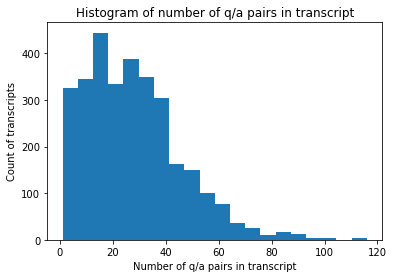

Total token count 6583595
Mean text token length 38.8156203571
Median text token length 25.0
SD text token length 47.1266417718


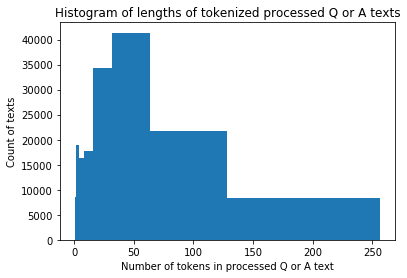

In [37]:
num_questions = []
procd_lengths = []

for file_id in qa_pairs:
    num_questions.append(len(qa_pairs[file_id]))
    for q_num in qa_pairs[file_id]:
        procd_lengths.append(len(qa_pairs[file_id][q_num][0]))
        procd_lengths.append(len(qa_pairs[file_id][q_num][1]))
        
print "Total number of transcripts", len(qa_pairs.keys())
print "Total number of q/a pairs", len(procd_lengths) / 2
print 


print "Mean number of q/a pairs in transcript", np.mean(num_questions)
print "Median number of q/a pairs in transcript", np.median(num_questions)
print "SD number of q/a pairs in transcript", np.std(num_questions)

plt.hist(num_questions, bins = 20)
# plt.hist(procd_lengths, bins = 20)
plt.xlabel("Number of q/a pairs in transcript")
plt.ylabel("Count of transcripts")
plt.title("Histogram of number of q/a pairs in transcript")
plt.show()

print 'Total token count', np.sum(procd_lengths)
print "Mean text token length", np.mean(procd_lengths)
print "Median text token length", np.median(procd_lengths)
print "SD text token length", np.std(procd_lengths)

plt.hist(procd_lengths, bins = [1,2,4,8,16,32,64,128,256])
# plt.hist(procd_lengths, bins = 20)
plt.xlabel("Number of tokens in processed Q or A text")
plt.ylabel("Count of texts")
plt.title("Histogram of lengths of tokenized processed Q or A texts")
plt.show()

In [38]:
rawtext_dir = LIBRARY_PATH+"saved_models/standard_preproc"
with open(LIBRARY_PATH+"/raw_qa_data.txt", "r") as f:
    rawtext_qa = json.loads(f.read())

In [45]:
# Find qa pairs of median length for examples to include
median_length = 25
poss_example = []
poss_pair = []

for file_id in rawtext_qa:
    for q_num in rawtext_qa[file_id]:
        if len(qa_pairs[file_id][q_num][0]) == 25 and len(qa_pairs[file_id][q_num][1]) == 25:
            poss_example.append(rawtext_qa[file_id][q_num])
            poss_pair.append((file_id, q_num))

In [47]:
for p in range(20):
    print "-"*50
    file_id = poss_pair[p][0]
    q_num = poss_pair[p][1]
    print rawtext_qa[file_id][q_num][0]
    print rawtext_qa[file_id][q_num][1]
    print
    print qa_pairs[file_id][q_num][0]
    print qa_pairs[file_id][q_num][1]
    print


--------------------------------------------------
Okay. And then I just wanted to verify, it sounded like from SCANA that one factor that drove their decision was the decision of Santee Cooper to not go forward. I just want to verify that your partners are pretty much, they're all together in terms of where you're at on the decision-making process there.
Yeah, we work very hard, Georgia Power works very hard as a co-owner. We've had a relationship with these folks for decades and we have a terrific relationship, among and between Oglethorpe and Miag and Dalton, and we work very hard to stay together on these issues and I feel confident we will.

[u'okay', u'want', u'verifi', u'sound', u'like', u'scana', u'one', u'factor', u'drove', u'decis', u'decis', u'sante', u'cooper', u'go', u'forward', u'want', u'verifi', u'partner', u'pretti', u'much', u'togeth', u'term', u'decis', u'make', u'process']
[u'yeah', u'work', u'hard', u'georgia', u'power', u'work', u'hard', u'co', u'owner', u'relatio

IndexError: list index out of range